In [656]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from functools import reduce
import itertools
import sklearn.datasets
import os
import re
%matplotlib inline

In [661]:
def plot(data, ax=None, enum=False, title='', labels=None, legend=False, **kwargs):
    axes_defined = ax != None
    if not axes_defined:
        fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    plotted = None
    if enum:
        plotted = ax.plot(data, **kwargs)
    else:
        mapping = np.array(data).T
        plotted = ax.plot(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ax.set_title(title)
    ax.grid(True)
    if not axes_defined:
        fig.tight_layout()
    return ax

def scatter(data, ax=None, enum=False, title='', labels=None, legend=False, colorbar=False, xlim=None, **kwargs):
    axes_defined = ax != None
    if not axes_defined:
        fig, ax = plt.subplots(1, 1, figsize=(13, 4))
    scattered = None
    if enum:
        scattered = ax.scatter(range(len(data)), data, **kwargs)
    else:
        mapping = np.array(data).T
        scattered = ax.scatter(mapping[0], mapping[1], **kwargs)
    if labels:
        ax.set_xlabel(labels[0])
        if (len(labels) > 1):
            ax.set_ylabel(labels[1])
    if legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    if xlim:
        ax.set_xlim(xlim)
    ax.set_title(title)
    ax.grid(True)
    if colorbar:
        cax = plt_ax.make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scattered, cax=cax)
        cbar.set_ticks([-1, 0, 1])
    if not axes_defined:
        fig.tight_layout()
    return ax

def heatmap(ax, data, title, policy=False):
    if policy:
        cmap = cm.get_cmap('jet')
        bounds = [-1] + list(range(len(actions) + 1))
        norm = colors.BoundaryNorm(bounds, cmap.N)
        cax = ax.imshow(data, extent=[-np.pi/4, np.pi/4, -3, 3], aspect="auto", interpolation='none', norm=norm)
    else:
        cax = ax.imshow(data, extent=[-np.pi/4, np.pi/4, -3, 3], aspect="auto", interpolation='none')
    ax.set_xlabel('angle')
    ax.set_ylabel('velocity')
    ax.set_title(title)
    plt.colorbar(cax, ax=ax)

### Global variables

In [19]:
l = 1  # m
m = 2  # kg
g = 9.81  # m / s^2
# Shape of state variable: (angle, velocity)

ACTION_SUB = -4  # N
ACTION_WAIT = 0  # N
ACTION_ADD = 4  # N
actions = (ACTION_SUB, ACTION_WAIT, ACTION_ADD)

In [53]:
def reward(state):
    angle, _ = state
    if abs(angle) > np.pi/4:
        return -1
    else:
        return 0

def is_failed(state):
    return reward(state) == -1

# Calculations for dynamics in a small timestamp dt = 0.02 s
def move(state, action, dt=0.02, sigma=3):
    angle, velocity = state
    epsilon = np.random.normal(0, sigma)
    next_velocity = velocity + (g / l) * np.sin(angle) * dt + (action / m) * dt + (epsilon / m) * dt
    next_angle = angle + next_velocity * dt
    # TODO: Add reward, etc.
    return (next_angle, next_velocity)

def simulate_uncontrolled():
    state = (0, 0)
    states = [state]
    while not is_failed(state) and len(states) < 1000:
        state = move(state, ACTION_WAIT)
        states.append(state)
    return state, states

### Exercise 14.1 (a) Uncontrolled Episodes

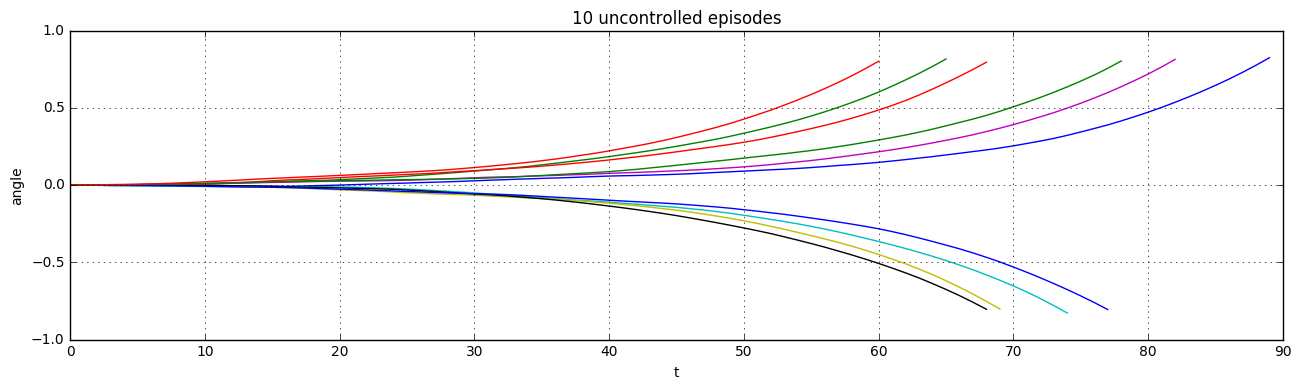

In [54]:
ax = None
for _ in range(10):
    final_state, all_states = simulate_uncontrolled()
    angles = [angle for angle, _ in all_states]
    ax = plot(angles, ax, enum=True, labels=['t', 'angle'], title='10 uncontrolled episodes')

### Exercise 14.1 (b) Discrete Spaces

In [481]:
def discretize(value, value_space):
    idx = (np.abs(value_space - value)).argmin()
    return value_space[idx], idx

def discrete_state(x, flatten=False, angle_range=angle_values, velocity_range=velocity_values):
    angle, velocity = x
    angle, angle_index = discretize(angle, angle_range)
    velocity, velocity_index = discretize(velocity, velocity_range)
    if flatten:
        return (angle, velocity), angle_index * len(velocity_range) + velocity_index
    return (angle, velocity), (angle_index, velocity_index)

In [564]:
D1 = 50
D2 = 50
angle_values = np.linspace(-np.pi/4, np.pi/4, D1).round(2)
velocity_values = np.linspace(-3, 3, D2).round(2)
discrete_space = list(itertools.product(angle_values, velocity_values))
# Draw 100.000 continuous states from the multivariant normal dist and map those to their discrete states
# FIXME: For some reason the following cov matrix doesn't work out: [[np.pi/8, 0], [0, 3/2]]
random_states = np.random.multivariate_normal([0, 0], [[np.pi/19, 0], [0, 4.5/2]], 100000)
# 50 x 50 image plot for the colorcoded amount of each discrete state
states = [discrete_state(x, angle_range=angle_values, velocity_range=velocity_values)[0] for x in random_states]
# Count occurences for each discrete state
counts = [states.count(disc_state) for disc_state in discrete_space]

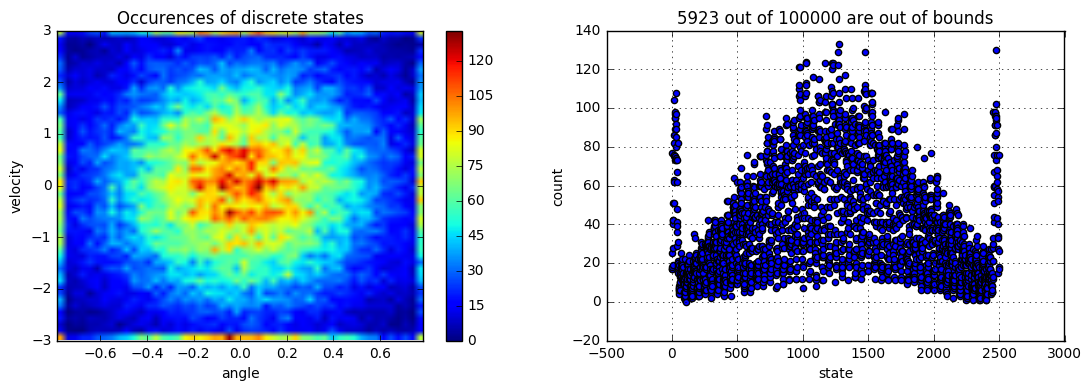

In [565]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
im = axes[0].imshow(np.reshape(counts, (50, 50)), extent=[-np.pi/4, np.pi/4, -3, 3], aspect="auto")
axes[0].set_title('Occurences of discrete states')
axes[0].set_xlabel('angle')
axes[0].set_ylabel('velocity')
plt.colorbar(im, ax=axes[0])
ax = scatter(counts, ax=axes[1], enum=True, labels=['state', 'count'], title='{} out of {} are out of bounds'.format(
    len(states) - len([x for x in states if -np.pi/4 <= x[0] <= np.pi/4 and -3 <= x[1] <= 3]),
    len(states)))

### Exercise 14.2 (a) Q-Learning with e-greedy policy

In [662]:
def egreedy_policy(Q, state_pos, action=None, e=0, seed=0):
    choice = -1
    randomize = np.random.RandomState(seed)
    if randomize.rand() < e or all(Q[state_pos] == 0):
        choice = randomize.randint(len(actions))
    else:
        # Find index of the best action optimizing Q[state, action]
        choice = Q[state_pos].argmax()
    if not action:
        return actions[choice], choice
    return int(action == choice)

def qlearning(Q, angle_values, velocity_values, eta=0.5, gamma=0.9, e=0):
    # SARSA algorithm for Q approximation (on policy)
    state, state_pos = discrete_state((0, 0), flatten=True,
                                      angle_range=angle_values, velocity_range=velocity_values)
    exact_state = state
    states = [state]
    seed = np.random.randint(100000)
    while not is_failed(state) and len(states) < 1000:
        r = reward(state)
        action, action_pos = egreedy_policy(Q, state_pos, e=e, seed=seed+len(states))
        exact_state = move(exact_state, action)
        next_state, next_state_pos = discrete_state(exact_state, flatten=True,
                                                    angle_range=angle_values, velocity_range=velocity_values)
        Q[state_pos, action_pos] += eta * (r + gamma * Q[next_state_pos].max() - Q[state_pos, action_pos])
        state, state_pos = next_state, next_state_pos
        states.append(state)
    # Add the reward value (-1 if failed)
    r = reward(state)
    action, action_pos = egreedy_policy(Q, state_pos, e=e, seed=seed+len(states))
    exact_state = move(exact_state, action)
    next_state, next_state_pos = discrete_state(exact_state, flatten=True,
                                                angle_range=angle_values, velocity_range=velocity_values)
    Q[state_pos, action_pos] += eta * (r + gamma * Q[next_state_pos].max() - Q[state_pos, action_pos])
    return Q, states

def train_qlearning(episodes=2000, D1=50, D2=50, eta=0.5, gamma=0.9, e=0, quiet=True):
    Q = np.zeros((D1 * D2, len(actions)))
    Qsteps = []
    angle_values = np.linspace(-np.pi/4, np.pi/4, D1).round(2)
    velocity_values = np.linspace(-3, 3, D2).round(2)
    D_space = np.array(list(itertools.product(angle_values, velocity_values)))
    for i in range(episodes):
        Q, Qstates = qlearning(Q, angle_values, velocity_values, eta, gamma, e)
        Qsteps.append(len(Qstates))
        if i % 200 == 0 and not quiet:
            print('Episode {} (D1={}, D2={})'.format(i, D1, D2))
    return Q, D_space, Qsteps

def plot_qlearning(Q, D_space, Qsteps, D1=50, D2=50, e=0):
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    Q_values = Q.sum(axis=1)
    Q_values[Q_values != 0] = -np.log(-Q_values[Q_values != 0])
    Q_values[Q_values == 0] = np.nan
    heatmap(axes[0], Q_values.reshape(D1, D2), 'Q given D1={}, D2={}'.format(D1, D2))
    # Plot policies
    policies = np.array([
            egreedy_policy(Q, i, e=e)[1] if any(Q[i] != 0) else -1
            for i in range(len(D_space))])
    cmap = colors.ListedColormap(['b','g','y','r'])
    bounds = [-1] + list(range(len(actions)))
    norm = colors.BoundaryNorm(bounds, cmap.N)
    heatmap(axes[1], policies.reshape(D1, D2), 'Greedy policy given D1={}, D2={}'.format(D1, D2), policy=True)
    fig.tight_layout()
    ax = plot(Qsteps, enum=True, title='Convergency', labels=['episode', 'steps'])
    ax.set_ylim([-1, 1001])

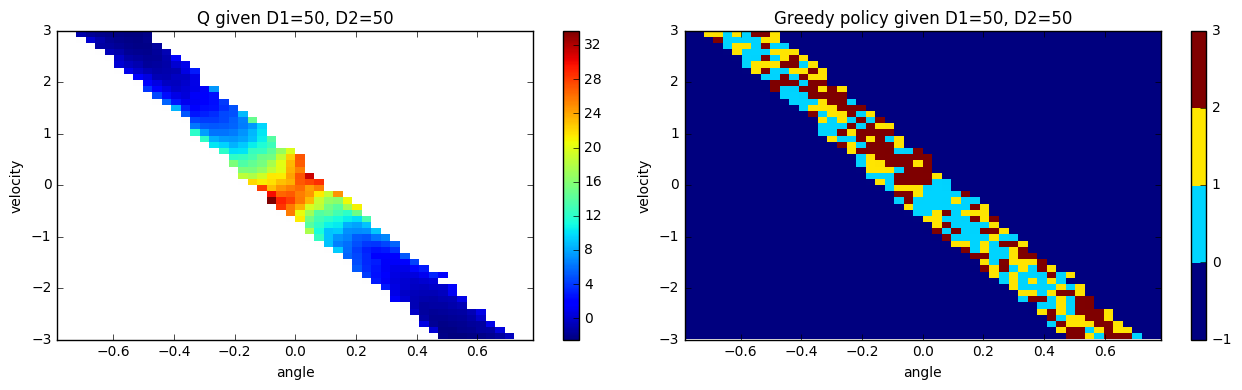

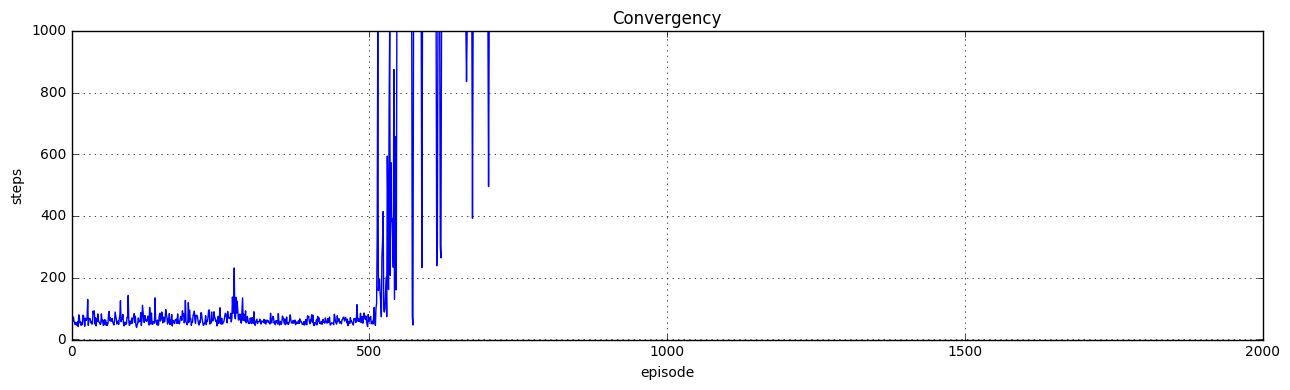

In [669]:
Q50, Q50_D_space, Q50_steps = train_qlearning()
plot_qlearning(Q50, Q50_D_space, Q50_steps)

### Exercise 14.2 (b) Changing D1 and D2

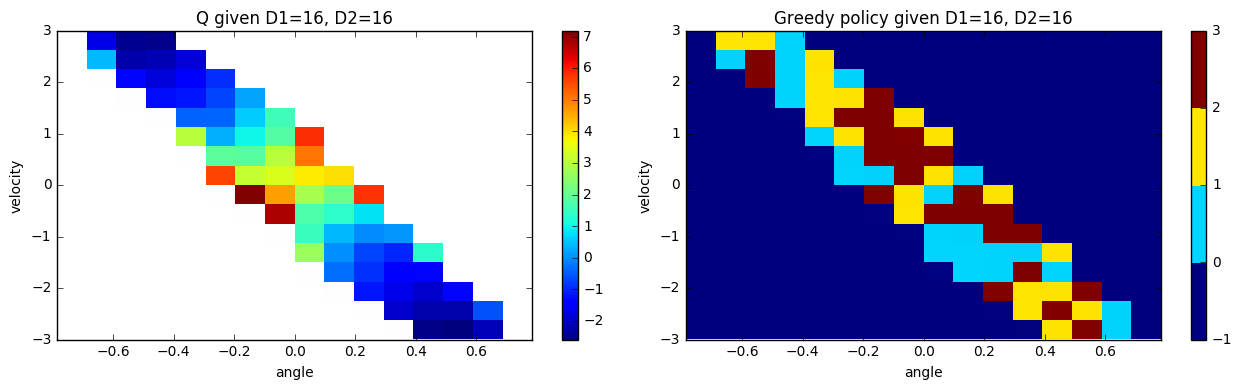

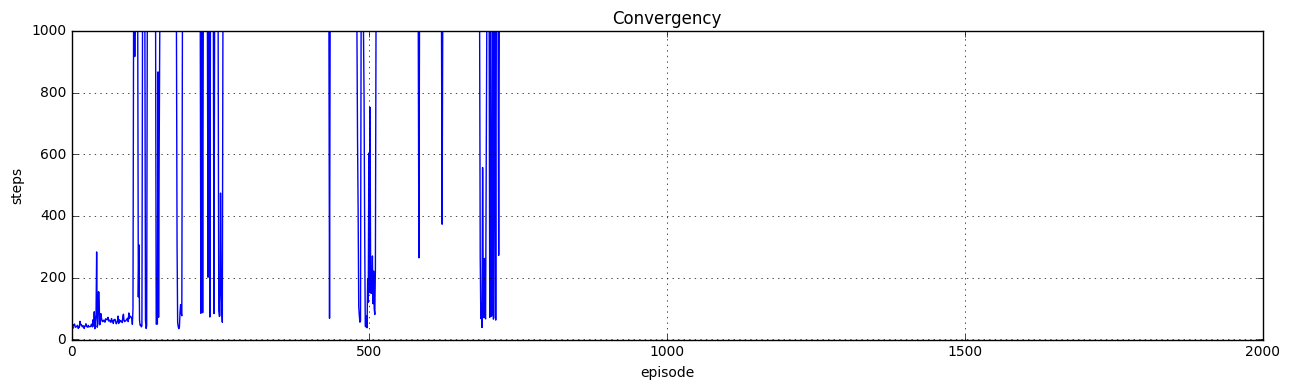

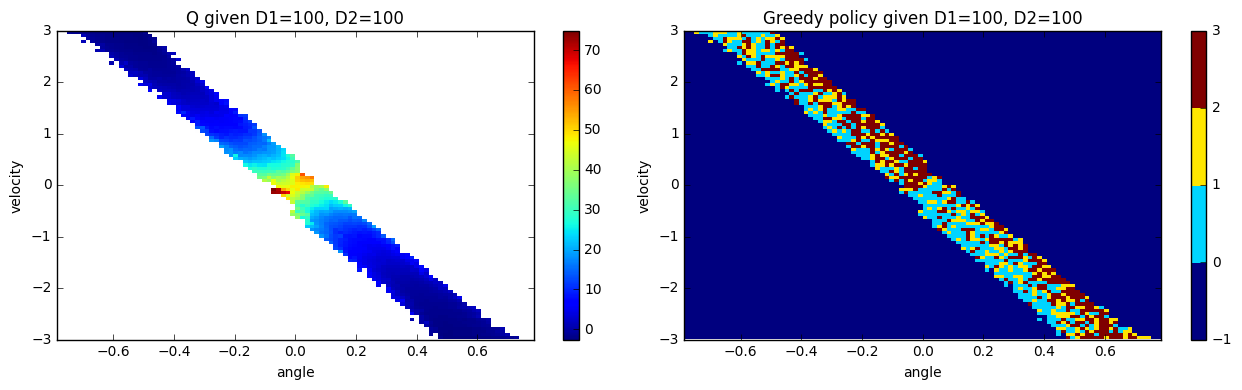

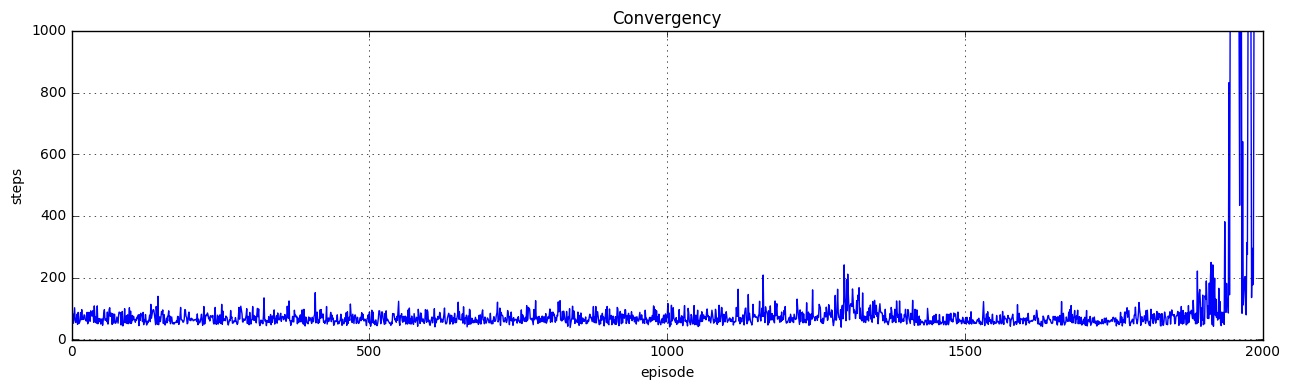

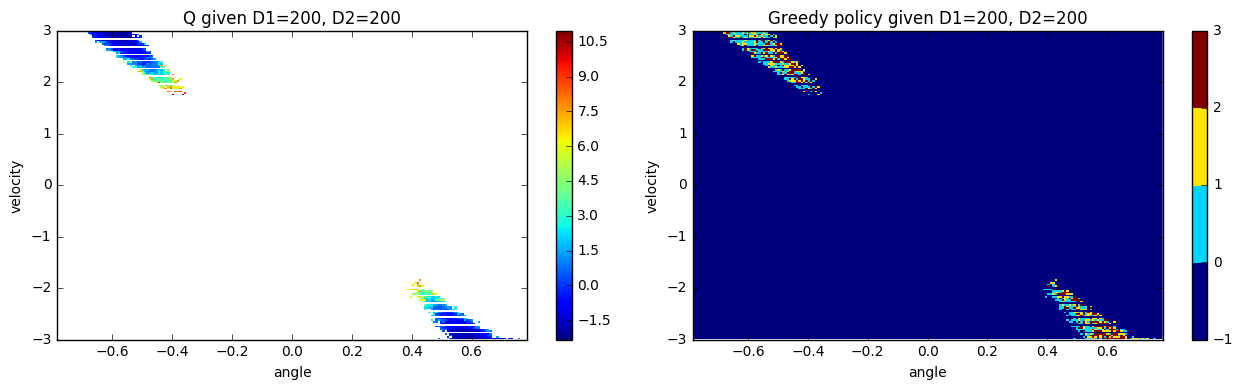

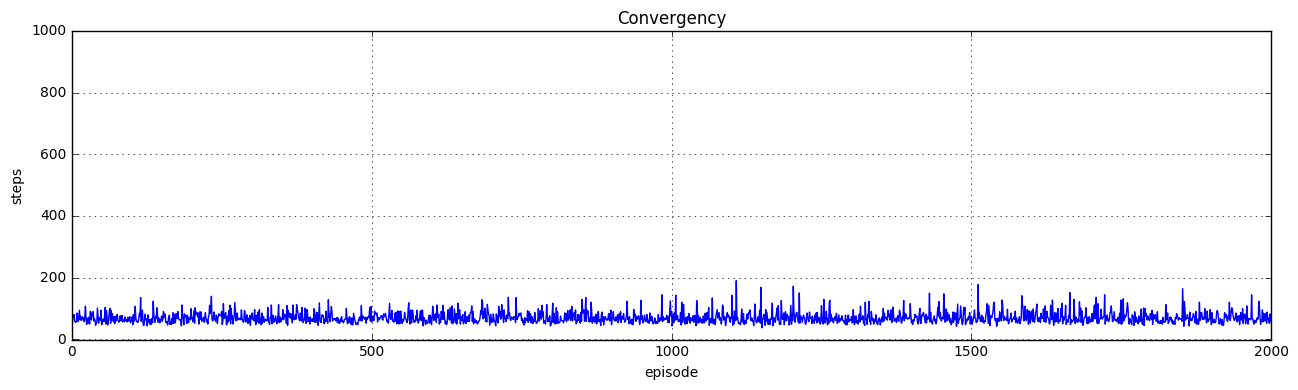

In [671]:
for D in (16, 100, 200):
    Q, D_space, Q_steps = train_qlearning(D1=D, D2=D)
    plot_qlearning(Q, D_space, Q_steps, D1=D, D2=D)

### 14.2 (c)
Smallest number that earns a good policy: Should be D1=D2=2, for me it was around 16

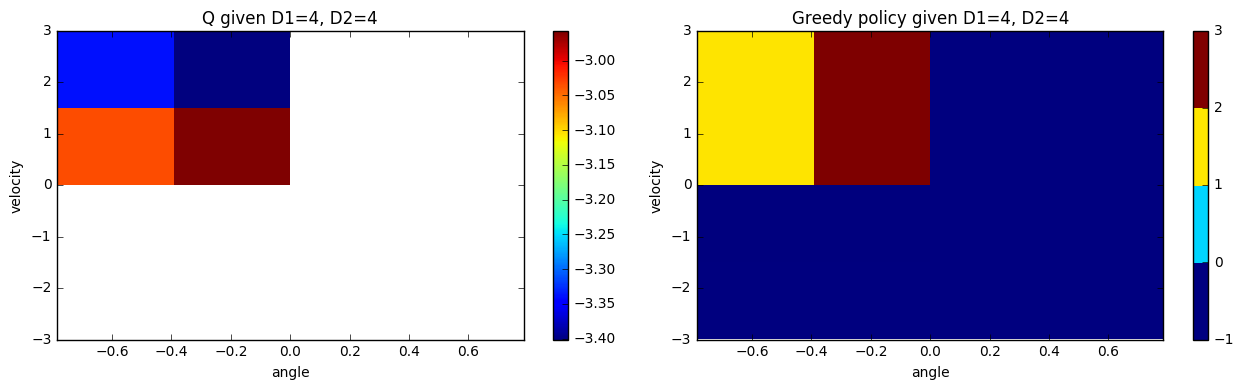

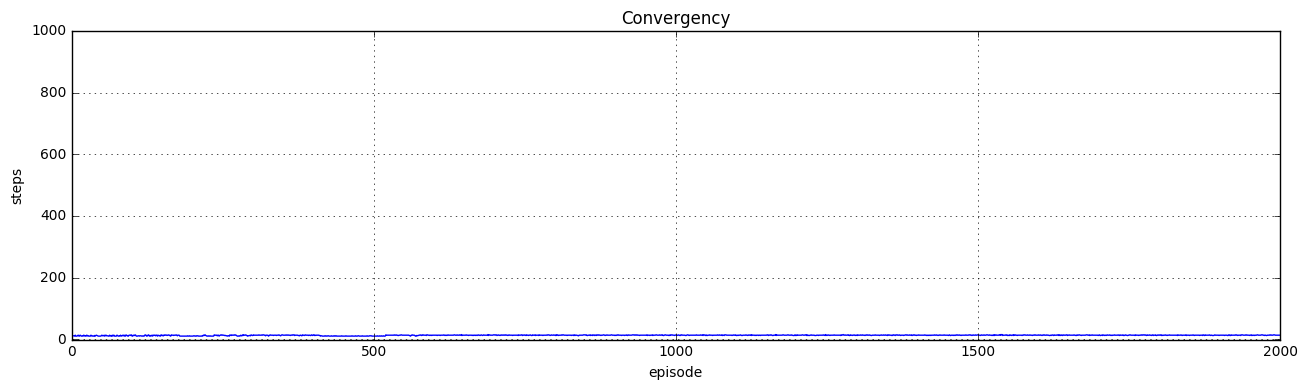

In [670]:
Q, D_space, Q_steps = train_qlearning(D1=4, D2=4)
plot_qlearning(Q, D_space, Q_steps, D1=4, D2=4)

### 14.2 (d) e-greedy policy (e = 0.1)

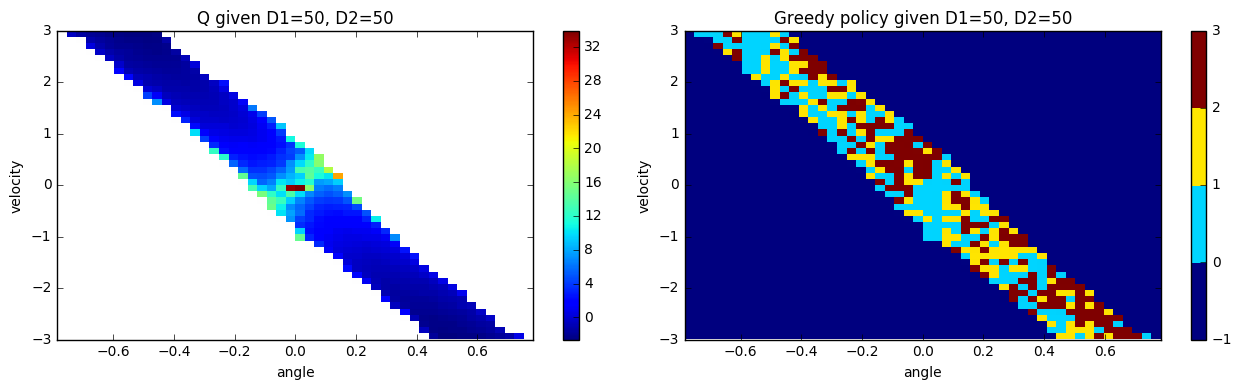

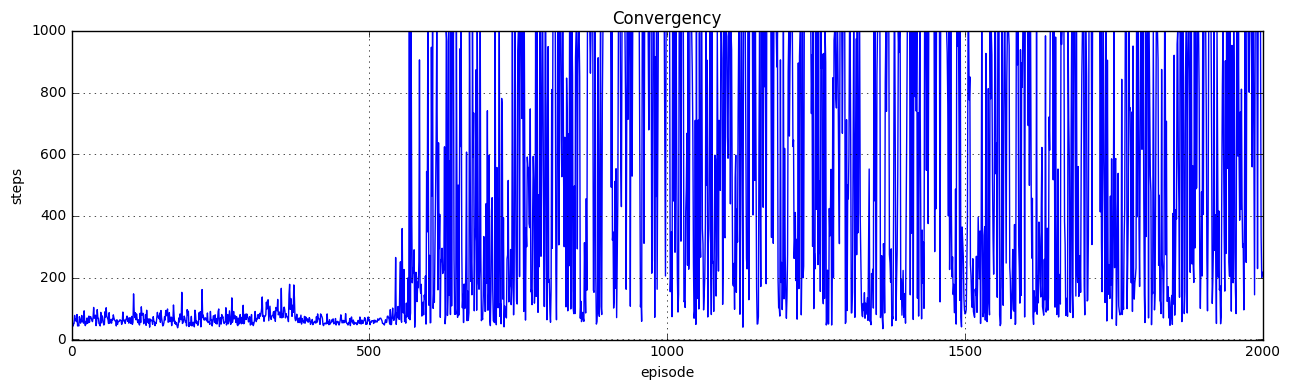

In [672]:
Qe, Qe_D_space, Q_steps = train_qlearning(e=0.1)
plot_qlearning(Qe, Qe_D_space, Q_steps, e=0.1)

### 14.2 (e) fast learning rate (eta = 1)

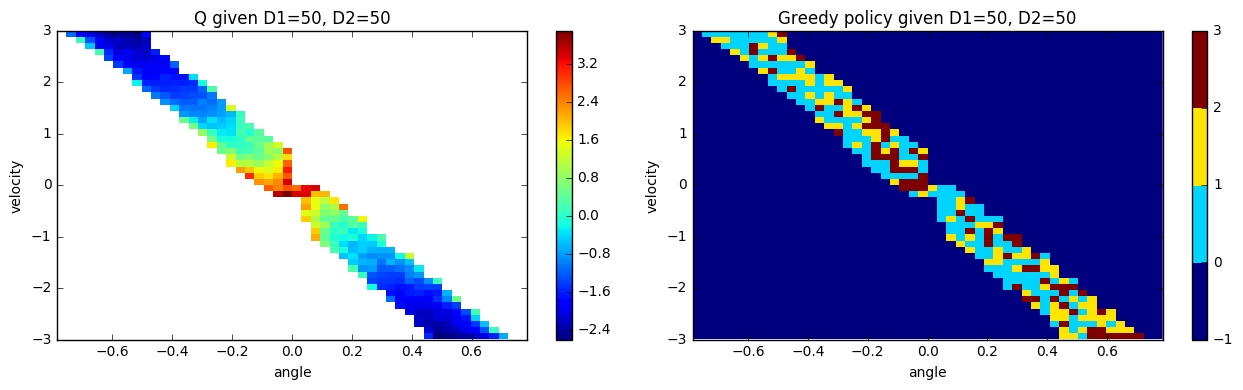

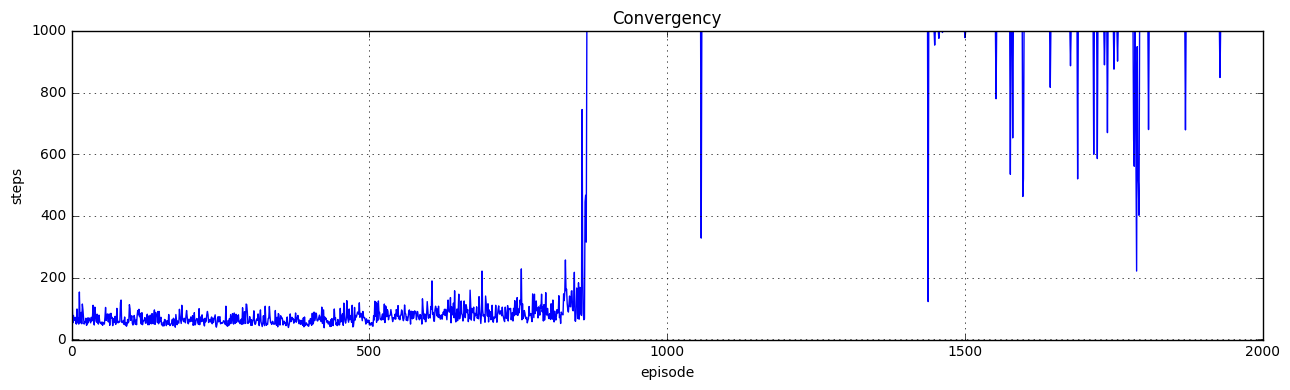

In [673]:
Qeta, Qeta_D_space, Qeta_steps = train_qlearning(eta=1)
plot_qlearning(Qeta, Qeta_D_space, Qeta_steps)